# Project 2: Fun with Filters and Frequencies

In [1]:
import numpy as np
import skimage as sk
from skimage.transform import resize
import skimage.transform as sktr
import skimage.io as skio
import math
import os
from tqdm import tqdm_notebook as tqdm
import time
import matplotlib.pyplot as plt
import cv2
from scipy import signal




import skimage.transform as sktr

<font size=4> Part 1: Fun with Filters</font><br>
<br>
Part 1.1: Fine Difference Operator<br>
We will begin by using the humble finite difference as our filter in the x and y directions.First, show the partial derivative in x and y of the cameraman image by convolving the image with finite difference operators D_x and D_y (you can use convolve2d from scipy.signal library). Now compute and show the gradient magnitude image. To turn this into an edge image, lets binarize the gradient magnitude image by picking the appropriate threshold (trying to suppress the noise while showing all the real edges; it will take you a few tries to find the right threshold).

Lossy conversion from float64 to uint8. Range [-0.8235294117647058, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.6823529411764706, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


1.0


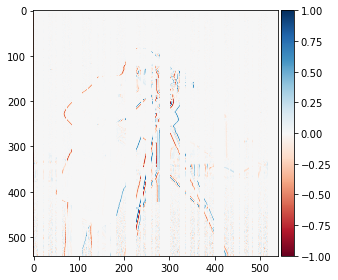

In [2]:
# read in the image (cameraman image) 
image = sk.io.imread(fname="cameraman.png", as_gray=True)
D_x=np.array([[1,-1]])
D_y=np.array([[1],[-1]])

grad_y = signal.convolve2d(image, D_y,  mode='same')
grad_x = signal.convolve2d(image, D_x,  mode='same')
print(np.max(grad_x))
fname = "out/Cameraman_x.png"
skio.imsave(fname, grad_x)
fname = "out/Cameraman_y.png"
skio.imsave(fname, grad_y)
skio.imshow(grad_x)
skio.show()

<ipython-input-3-12baf85f84ab>:15: UserWarning: out/Cameraman_edge.png is a low contrast image
  skio.imsave(fname, pixel)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1.4142135623730951]. Convert image to uint8 prior to saving to suppress this warning.


0.16970562748477142


/Users/jingyuan/opt/anaconda3/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


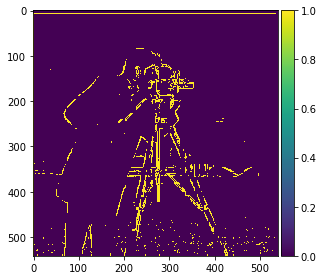

In [3]:
#find the right threshold for horizontal edge and vertical adge
def edge(grad_y,grad_x,alpha):
    Y = (grad_y) **2
    X = (grad_x) **2
    output=Y + X
    Output = np.sqrt(output)

    pixel_max=np.max(Output)*alpha
    print(pixel_max)
    pixel=np.where(Output<pixel_max, 0, 1)
    return pixel,Output

pixel,Output=edge(grad_y,grad_x,0.12)
fname = "out/Cameraman_edge.png"
skio.imsave(fname, pixel)
fname = "out/Cameraman_magni.png"
skio.imsave(fname, Output)
skio.imshow(pixel)
skio.show()

Part 1.2: Derivative of Gaussian (DoG) Filter<br>
We noted that the results with just the difference operator were rather noisy. Luckily, we have a smoothing operator handy: the Gaussian filter G. Create a blurred version of the original image by convolving with a gaussian and repeat the procedure in the previous part (one way to create a 2D gaussian filter is by using cv2.getGaussianKernel() to create a 1D gaussian and then taking an outer product with its transpose to get a 2D gaussian kernel). What differences do you see? Now we can do the same thing with a single convolution instead of two by creating a derivative of gaussian filters. Convolve the gaussian with D_x and D_y and display the resulting DoG filters as images. Verify that you get the same result as before.

<ipython-input-4-cbba39faaa73>:14: UserWarning: out/Cameraman_blur1.png is a low contrast image
  skio.imsave(fname, Pixel)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.056188024188630226


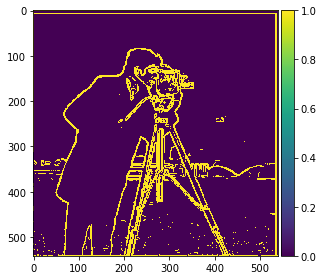

In [4]:
image = sk.io.imread(fname="cameraman.png", as_gray=True)
G_1D=cv2.getGaussianKernel(5,1)

#2D Gaussian convolution
G_2D=np.outer(G_1D,G_1D.T)
image_G = signal.convolve2d(image, G_2D,  mode='same')

image_G_x= signal.convolve2d(image_G, D_x,  mode='same')
image_G_y= signal.convolve2d(image_G, D_y, mode='same')

#find the right threshold for horizontal edge and vertical adge
Pixel,Output=edge(image_G_y,image_G_x,0.08)
fname = "out/Cameraman_blur1.png"
skio.imsave(fname, Pixel)
skio.imshow(Pixel)

<ipython-input-5-38a594850cf6>:11: UserWarning: out/Cameraman_blur2.png is a low contrast image
  skio.imsave(fname, Pixel)
Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


0.08348624863585646


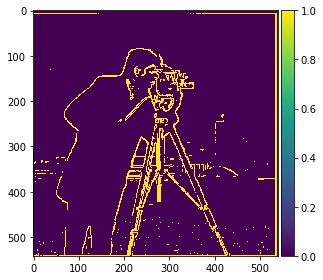

In [5]:
#Derivative of Gaussian convolution
D_G_y = signal.convolve2d(G_2D,D_y,  mode='same')
D_G_x = signal.convolve2d(G_2D,D_x,  mode='same')

image_D_G_y = signal.convolve2d(image, D_G_y,  mode='same')
image_D_G_x = signal.convolve2d(image, D_G_x,  mode='same')

#find the right threshold for horizontal edge and vertical adge
Pixel,Output=edge(image_D_G_y,image_D_G_x,0.2)
fname = "out/Cameraman_blur2.png"
skio.imsave(fname, Pixel)
skio.imshow(Pixel)

<font size=3>Reason:<font><br>
Because there is rule that convolution is a multiplication-like operation. So there is A*(B*C)=(A*B)*C.

Part 1.3: Image Straightening<br>
Remember the last time when you took a photo from your phone and the image was not straight. You probably tried rotating the image manually to straighten it. In this problem, you will automate the image straightening process to save some time! It is known that statistically there is a preference for vertical and horizontal edges in most images (due to gravity!). We will use this insight by trying to rotate an image to maximize the number of vertical and horizontal edges. To straighten an image, generate a set of proposed rotations. For each proposed rotation angle <br>
--Rotate the image by the proposed rotation angle using the built in rotation function in python/matlab (e.g. scipy.ndimage.interpolation.rotate in python).<br>
--Compute the gradient angle of the edges in the image (but ignore the edges of the image created by rotation itself; one simple way of doing this is to always crop the center part of the image).<br>
--Compute a histogram of these angles (e.g. matplotlib.pyplot.hist in python).<br>
Finally, pick the rotation with the maximum number of horizontal and vertical edges. Show the orientation histogram and straightening result for the image below (download here):<br>


<ipython-input-6-1815956c0fb9>:15: RuntimeWarning: divide by zero encountered in true_divide
  tan=image_y/image_x
<ipython-input-6-1815956c0fb9>:15: RuntimeWarning: invalid value encountered in true_divide
  tan=image_y/image_x
/Users/jingyuan/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jingyuan/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


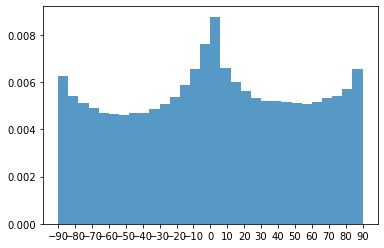

In [6]:
from scipy import ndimage, misc

image = sk.io.imread(fname="facade5.jpeg",as_gray=True)

#blur first than find contrast
image_G = signal.convolve2d(image, G_2D,  mode='same')

image_x= signal.convolve2d(image_G, D_x,  mode='same')
image_y= signal.convolve2d(image_G, D_y,  mode='same')

#Compute the gradient angle of the edges in the image
x,y=image_G_x.shape
image_x=(image_x[int(x*0.2):int(-x*0.2),int(y*0.2):int(-y*0.2)])
image_y=(image_y[int(x*0.2):int(-x*0.2),int(y*0.2):int(-y*0.2)])
tan=image_y/image_x
theta=np.degrees(np.arctan(tan))
hist=theta.flatten().tolist()
# the histogram of the original image
plt.hist(hist, 30, density=True, alpha=0.75)
plt.xticks([-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90])
plt.show()


<ipython-input-7-6137fd4b8bd8>:4: RuntimeWarning: invalid value encountered in less
  theta_v[theta_v <80] = None
<ipython-input-7-6137fd4b8bd8>:5: RuntimeWarning: invalid value encountered in greater
  theta_h[theta_h >10] = None


-4.604360201986602


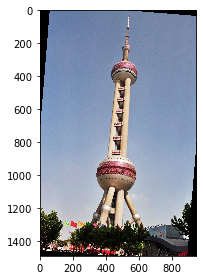

In [7]:
#find the maximum number of horizontal and vertical edges
theta_v=abs(theta)
theta_h=abs(theta)
theta_v[theta_v <80] = None
theta_h[theta_h >10] = None
v=90-np.nanmean(abs(theta_v))
h=np.nanmean(abs(theta_h))

#rotate the photo
image = sk.io.imread(fname="facade5.jpeg")
inputs_plusx_img = ndimage.interpolation.rotate(image, -(v+h)/2, reshape=False)
print(-(v+h)/2)
fname = "out/facade5_blur2.jpg"
skio.imsave(fname, inputs_plusx_img)
skio.imshow(inputs_plusx_img)

<ipython-input-8-038dc377b305>:12: RuntimeWarning: divide by zero encountered in true_divide
  tan=image_y/image_x
<ipython-input-8-038dc377b305>:12: RuntimeWarning: invalid value encountered in true_divide
  tan=image_y/image_x


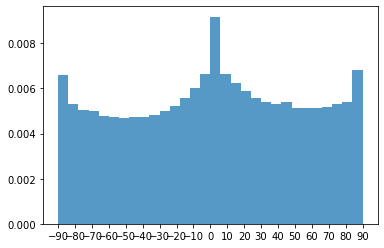

In [8]:
#get the histgram of angle distribution
image = sk.io.imread(fname="out/facade5_blur2.jpg",as_gray=True)
image_G = signal.convolve2d(image, G_2D,  mode='same')

image_x= signal.convolve2d(image_G, D_x,  mode='same')
image_y= signal.convolve2d(image_G, D_y,  mode='same')

#Compute the gradient angle of the edges in the image
x,y=image_G_x.shape
image_x=(image_x[int(x*0.2):int(-x*0.2),int(y*0.2):int(-y*0.2)])
image_y=(image_y[int(x*0.2):int(-x*0.2),int(y*0.2):int(-y*0.2)])
tan=image_y/image_x
theta=np.degrees(np.arctan(tan))
hist=theta.flatten().tolist()
# the histogram of the original image
plt.hist(hist, 30, density=True, alpha=0.75)
plt.xticks([-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90])
plt.show()

<font size=4> Part 2: Fun with Frequencies!</font><br>
<br>
Part 2.1: Image "Sharpening"<br>
Pick your favorite blurry image and get ready to "sharpen" it! We will derive the unsharp masking technique. Remember our favorite Gaussian filter from class. This is a low pass filter that retains only the low frequencies. We can subtract the blurred version from the original image to get the high frequencies of the image. An image often looks sharper if it has stronger high frequencies. So, lets add a little bit more high frequencies to the image! Combine this into a single convolution operation which is called the unsharp mask filter. Show your result on the following image (download here) plus other images of your choice --

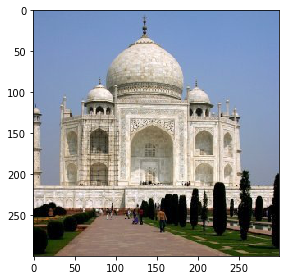

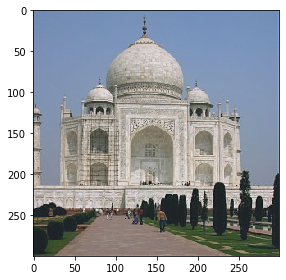

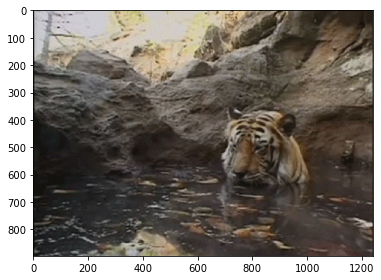

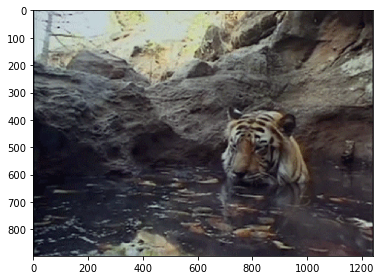

In [3]:
#read in the blurry image
G_1D=cv2.getGaussianKernel(5,1)
#2D Gaussian convolution
G_2D=np.outer(G_1D,G_1D.T)

files=["taj","tiger"]
for file in files:
    image = sk.io.imread(fname=file+".jpg")
    skio.imshow(image)
    skio.show()
    #enhanced image = original + amount * (original - blurred)
    #blur first than find contrast
    color=[]
    for i in range(3):
        image_G = signal.convolve2d(image[:,:,i], G_2D,  mode='same')
        alpha=0.5
        enhanced_image=image[:,:,i]+alpha*(image[:,:,i]-image_G)
        enhanced_image = (enhanced_image-np.min(enhanced_image))/(np.max(enhanced_image)-np.min(enhanced_image))
        image[:,:,i]=enhanced_image*255

    fname = "out/"+file+"_sharp.jpg"
    skio.imsave(fname, image)
    skio.imshow(image)
    skio.show()

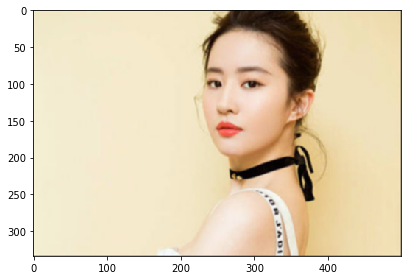

In [10]:
#blur then sharp
image = sk.io.imread(fname="liuyifei.jpg")

#enhanced image = original + amount * (original - blurred)
G_1D=cv2.getGaussianKernel(5,1)
#2D Gaussian convolution
G_2D=np.outer(G_1D,G_1D.T)

#blur the sharp image 
for i in range(3):
    image_G = signal.convolve2d(image[:,:,i], G_2D,  mode='same')
    image[:,:,i]=image_G
fname = "out/liuyifei_blur2.jpg"
skio.imsave(fname, image)
#then blur first than find contrast
color=[]
for i in range(3):
    image_G = signal.convolve2d(image[:,:,i], G_2D,  mode='same')
    image_G = signal.convolve2d(image[:,:,i], G_2D,  mode='same')
    alpha=0.5
    enhanced_image=image[:,:,i]+alpha*(image[:,:,i]-image_G)
    enhanced_image = (enhanced_image-np.min(enhanced_image))/(np.max(enhanced_image)-np.min(enhanced_image))
    image[:,:,i]=enhanced_image*255

fname = "out/liuyifei_sharp.jpg"
skio.imsave(fname, image)
skio.imshow(image)
skio.show()

Part 2.2: Hybrid Images<br>
The goal of this part of the assignment is to create hybrid images using the approach described in the SIGGRAPH 2006 paper by Oliva, Torralba, and Schyns. Hybrid images are static images that change in interpretation as a function of the viewing distance. The basic idea is that high frequency tends to dominate perception when it is available, but, at a distance, only the low frequency (smooth) part of the signal can be seen. By blending the high frequency portion of one image with the low-frequency portion of another, you get a hybrid image that leads to different interpretations at different distances.

In [11]:

def hybrid_image(im1, im2, sigma1, sigma2):
    #low-frequency filter
    G_1D=cv2.getGaussianKernel(30,15)
    G_2D=np.outer(G_1D,G_1D.T)
    im1_af = signal.convolve2d(im1, G_2D, mode='same')

    #high-frequency filter
    G_1D=cv2.getGaussianKernel(20,15)
    #2D Gaussian convolution
    G_2D=np.outer(G_1D,G_1D.T)
    im2_a = signal.convolve2d(im2, G_2D,  mode='same')
    im2_af=im2-im2_a
    
    hybrid=sigma1*im1_af+sigma2*im2_af
    hybrid = (hybrid-np.min(hybrid))/(np.max(hybrid)-np.min(hybrid))
    return hybrid


In [12]:
# import align_image_code as align
# import matplotlib
# matplotlib.use('TkAgg')

# image1= sk.io.imread(fname="DerekPicture.jpg")
# image2= sk.io.imread(fname="nutmeg.jpg")

# image2_a,image1_a=align.align_images(image2,image1)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


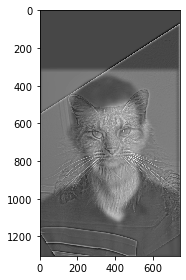

In [13]:
#Hybrid two images
image1= sk.io.imread(fname="DerekPicture_align.jpg",as_gray=True)
image2= sk.io.imread(fname="nutmeg_align.jpg",as_gray=True)

hybrid=hybrid_image(image1, image2, 0.3, 0.5)
fname = "out/hybrid.jpg"
skio.imsave(fname, hybrid)
skio.imshow(hybrid)
skio.show()


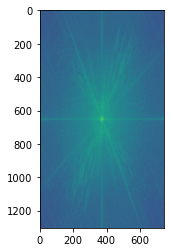

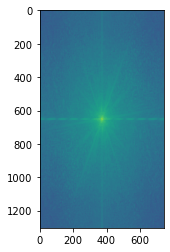

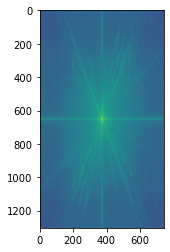

In [14]:
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(hybrid)))))
plt.show()
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(image1)))))
plt.show()
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(image2)))))
plt.show()

In [15]:
# import align_image_code as align
# import matplotlib
# matplotlib.use('TkAgg')

# image1= sk.io.imread(fname="sad.jpg")
# image2= sk.io.imread(fname="smile.jpg")

# image2_a,image1_a=align.align_images(image2,image1)
# fname1 = "sad_align.jpg"
# fname2 = "smile_align.jpg"
# skio.imsave(fname1, image1_a)
# skio.imsave(fname2, image2_a)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


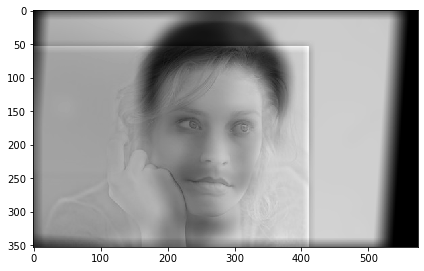

In [16]:
#Hybrid two images
image1= sk.io.imread(fname="sad_align.jpg",as_gray=True)
image2= sk.io.imread(fname="smile_align.jpg",as_gray=True)

hybrid=hybrid_image(image2, image1, 0.1, 8)
fname = "out/hybrid1.jpg"
skio.imsave(fname, hybrid)
skio.imshow(hybrid)
skio.show()

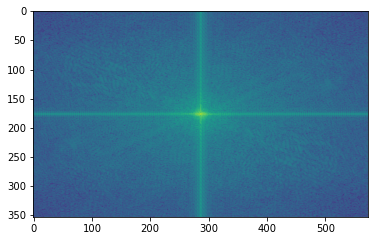

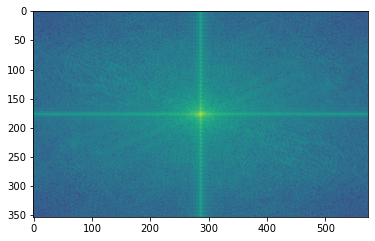

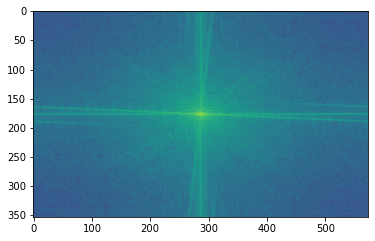

In [17]:
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(hybrid)))))
plt.show()
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(image1)))))
plt.show()
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(image2)))))
plt.show()

Part 2.3: Gaussian and Laplacian Stacks<br>
In this part you will implement Gaussian and Laplacian stacks, which are kind of like pyramids but without the downsampling. Then you will use these to analyze some images, and your results from part 1.2.<br>
-Implement a Gaussian and a Laplacian stack. The different between a stack and a pyramid is that in each level of the pyramid the image is downsampled, so that the result gets smaller and smaller. In a stack the images are never downsampled so the results are all the same dimension as the original image, and can all be saved in one 3D matrix (if the original image was a grayscale image). To create the successive levels of the Gaussian Stack, just apply the Gaussian filter at each level, but do not subsample. In this way we will get a stack that behaves similarly to a pyramid that was downsampled to half its size at each level. If you would rather work with pyramids, you may implement pyramids other than stacks. However, in any case, you are NOT allowed to use matlab's impyramid() and its equivalents in this project. You must implement your stacks from scratch!<br>
-Apply your Gaussian and Laplacian stacks to one interesting image that contain structure in multiple resolution such as paintings like the Salvador Dali painting of Lincoln and Gala we saw in class, or the Mona Lisa. Display your stacks computed from the image to discover the structure at each resolution.<br>
-Illustrate the process you took to create your hybrid images in part 2 by applying your Gaussian and Laplacian stacks and displaying them for your favorite result (one example). This should look similar to Figure 7 in the Oliva et al. paper.<br>

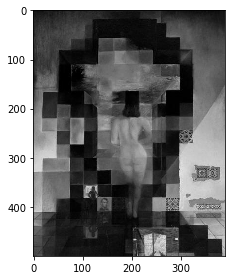

In [18]:
image= sk.io.imread(fname="lincoln.jpg", as_gray=True)
skio.imshow(image)
skio.show()

In [19]:
G_1D=cv2.getGaussianKernel(5,3)
#2D Gaussian convolution
G_2D=np.outer(G_1D,G_1D.T)

def blur(im):
    image_G = signal.convolve2d(im, G_2D,  mode='same')
    return image_G
def blur_mono(image):
    shape=image.shape
    image_new= signal.convolve2d(image, G_2D,  mode='same')    
    return image_new

def parmid_mono(num,image):
    G_image=[]
    L_image=[]
    for i in range(num):
        if i==0:
            image1=blur_mono(image)
            G_image.append(image1)

            
            image_delta=image-image1
            L_image.append(image_delta)
            
        else:
            image1=blur_mono(G_image[i-1])
            G_image.append(image1)
            
            image_delta=G_image[i-1]-image1
            L_image.append(image_delta)

    return G_image,L_image



Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


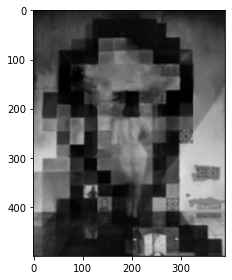

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


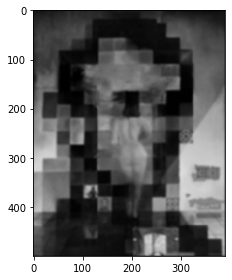

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


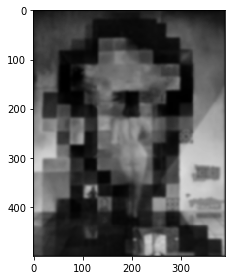

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


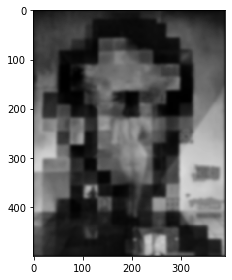

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


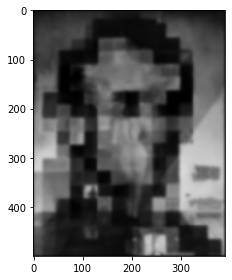

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


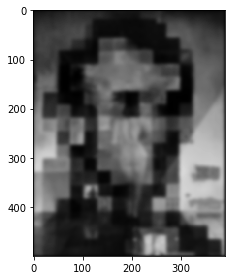

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


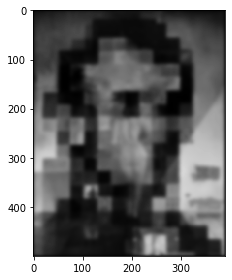

Lossy conversion from float64 to uint8. Range [-0.43739925272448665, 0.48682133383756454]. Convert image to uint8 prior to saving to suppress this warning.


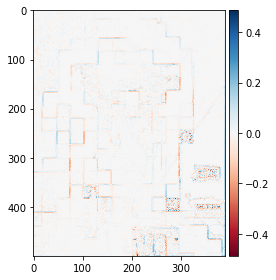

<ipython-input-28-28d18fabcf0e>:12: UserWarning: out/lincoln_Laplacian2.jpg is a low contrast image
  skio.imsave(fname, L[idex])
Lossy conversion from float64 to uint8. Range [-0.08689697474137348, 0.1550575661785195]. Convert image to uint8 prior to saving to suppress this warning.


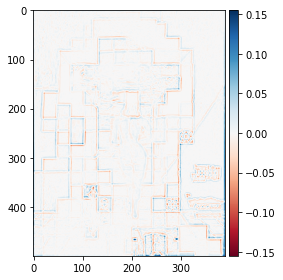

<ipython-input-28-28d18fabcf0e>:12: UserWarning: out/lincoln_Laplacian3.jpg is a low contrast image
  skio.imsave(fname, L[idex])
Lossy conversion from float64 to uint8. Range [-0.04206549033340046, 0.10304672639122636]. Convert image to uint8 prior to saving to suppress this warning.


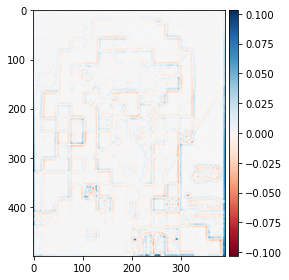

<ipython-input-28-28d18fabcf0e>:12: UserWarning: out/lincoln_Laplacian4.jpg is a low contrast image
  skio.imsave(fname, L[idex])
Lossy conversion from float64 to uint8. Range [-0.03232510430754426, 0.07491447855673]. Convert image to uint8 prior to saving to suppress this warning.


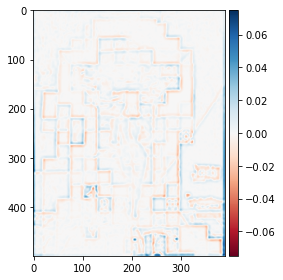

<ipython-input-28-28d18fabcf0e>:12: UserWarning: out/lincoln_Laplacian5.jpg is a low contrast image
  skio.imsave(fname, L[idex])
Lossy conversion from float64 to uint8. Range [-0.02547173756449228, 0.058248013094672146]. Convert image to uint8 prior to saving to suppress this warning.


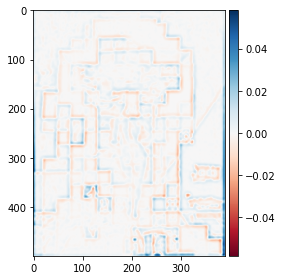

<ipython-input-28-28d18fabcf0e>:12: UserWarning: out/lincoln_Laplacian6.jpg is a low contrast image
  skio.imsave(fname, L[idex])
Lossy conversion from float64 to uint8. Range [-0.02072994857720517, 0.046774776037766586]. Convert image to uint8 prior to saving to suppress this warning.


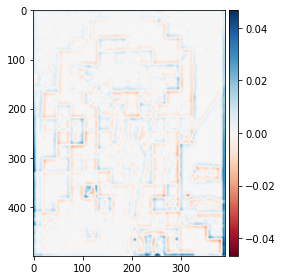

<ipython-input-28-28d18fabcf0e>:12: UserWarning: out/lincoln_Laplacian7.jpg is a low contrast image
  skio.imsave(fname, L[idex])
Lossy conversion from float64 to uint8. Range [-0.017268288100664553, 0.038240999693062994]. Convert image to uint8 prior to saving to suppress this warning.


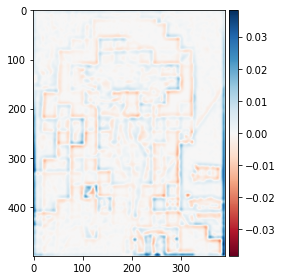

In [28]:
image= sk.io.imread(fname="lincoln.jpg", as_gray=True)
num=7
G,L=parmid_mono(num,image)

for idex,i in enumerate(G):
    fname = "out/lincoln_gaussian"+str(idex+1)+".jpg"
    skio.imsave(fname, G[idex])
    skio.imshow(G[idex])
    skio.show()
for idex,i in enumerate(L):
    fname = "out/lincoln_Laplacian"+str(idex+1)+".jpg"
    skio.imsave(fname, L[idex])
    skio.imshow(L[idex])
    skio.show()

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


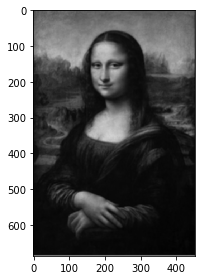

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


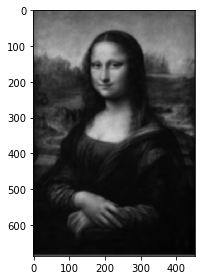

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


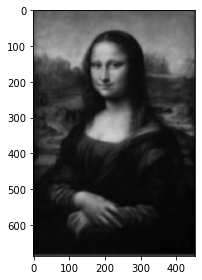

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


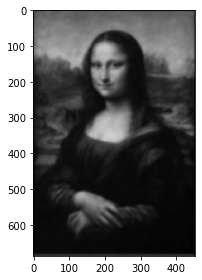

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


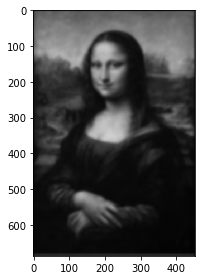

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


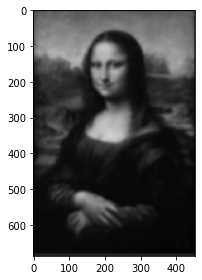

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


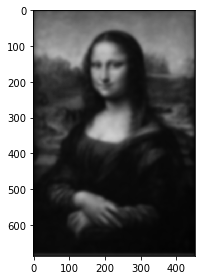

Lossy conversion from float64 to uint8. Range [-0.280890336762107, 0.704755310097368]. Convert image to uint8 prior to saving to suppress this warning.


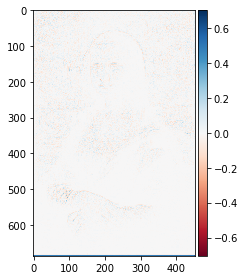

<ipython-input-30-4c92149f2a2b>:12: UserWarning: out/monalisa_Laplacian2.jpg is a low contrast image
  skio.imsave(fname, L[idex])
Lossy conversion from float64 to uint8. Range [-0.0947187269284582, 0.20597808598549236]. Convert image to uint8 prior to saving to suppress this warning.


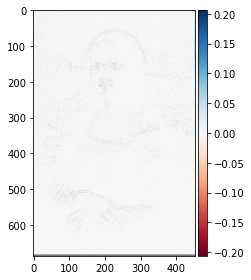

<ipython-input-30-4c92149f2a2b>:12: UserWarning: out/monalisa_Laplacian3.jpg is a low contrast image
  skio.imsave(fname, L[idex])
Lossy conversion from float64 to uint8. Range [-0.04114637768606261, 0.0946265693222528]. Convert image to uint8 prior to saving to suppress this warning.


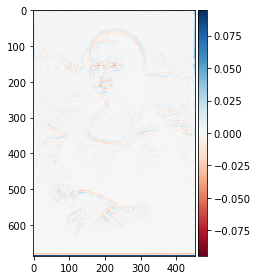

<ipython-input-30-4c92149f2a2b>:12: UserWarning: out/monalisa_Laplacian4.jpg is a low contrast image
  skio.imsave(fname, L[idex])
Lossy conversion from float64 to uint8. Range [-0.029880099691938222, 0.05699250250073262]. Convert image to uint8 prior to saving to suppress this warning.


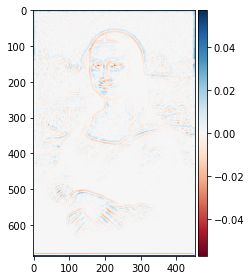

<ipython-input-30-4c92149f2a2b>:12: UserWarning: out/monalisa_Laplacian5.jpg is a low contrast image
  skio.imsave(fname, L[idex])
Lossy conversion from float64 to uint8. Range [-0.022500709727369422, 0.03866515028962339]. Convert image to uint8 prior to saving to suppress this warning.


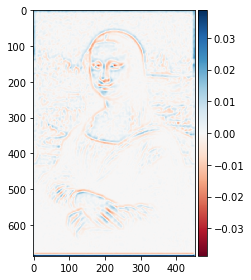

<ipython-input-30-4c92149f2a2b>:12: UserWarning: out/monalisa_Laplacian6.jpg is a low contrast image
  skio.imsave(fname, L[idex])
Lossy conversion from float64 to uint8. Range [-0.017409519315694594, 0.028980107760682217]. Convert image to uint8 prior to saving to suppress this warning.


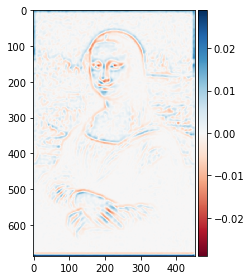

<ipython-input-30-4c92149f2a2b>:12: UserWarning: out/monalisa_Laplacian7.jpg is a low contrast image
  skio.imsave(fname, L[idex])
Lossy conversion from float64 to uint8. Range [-0.014272555911156087, 0.02232749630811784]. Convert image to uint8 prior to saving to suppress this warning.


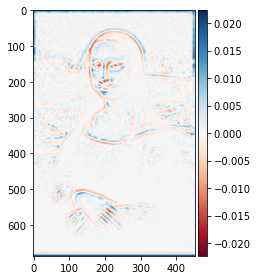

In [30]:
image= sk.io.imread(fname="monalisa.jpg", as_gray=True)
num=7
G,L=parmid_mono(num,image)

for idex,i in enumerate(G):
    fname = "out/monalisa_gaussian"+str(idex+1)+".jpg"
    skio.imsave(fname, G[idex])
    skio.imshow(G[idex])
    skio.show()
for idex,i in enumerate(L):
    fname = "out/monalisa_Laplacian"+str(idex+1)+".jpg"
    skio.imsave(fname, L[idex])
    skio.imshow(L[idex])
    skio.show()

Lossy conversion from float64 to uint8. Range [22.431108712625857, 219.65419767946932]. Convert image to uint8 prior to saving to suppress this warning.


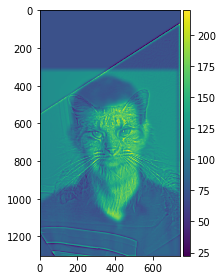

Lossy conversion from float64 to uint8. Range [16.856171519720476, 211.3758816774768]. Convert image to uint8 prior to saving to suppress this warning.


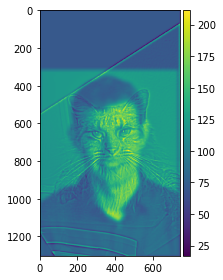

Lossy conversion from float64 to uint8. Range [12.230281792660259, 205.19721410072432]. Convert image to uint8 prior to saving to suppress this warning.


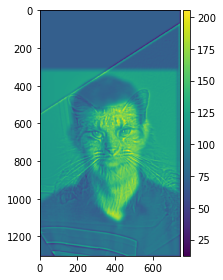

Lossy conversion from float64 to uint8. Range [9.61159731662363, 200.28834449646976]. Convert image to uint8 prior to saving to suppress this warning.


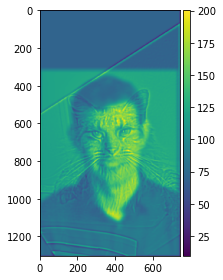

Lossy conversion from float64 to uint8. Range [7.914713742237245, 196.1890013921674]. Convert image to uint8 prior to saving to suppress this warning.


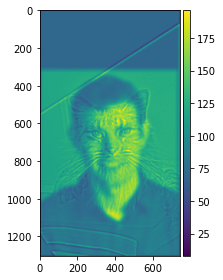

Lossy conversion from float64 to uint8. Range [6.72747441233581, 192.66830075776917]. Convert image to uint8 prior to saving to suppress this warning.


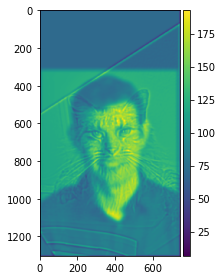

Lossy conversion from float64 to uint8. Range [5.849940439358091, 190.86125481728192]. Convert image to uint8 prior to saving to suppress this warning.


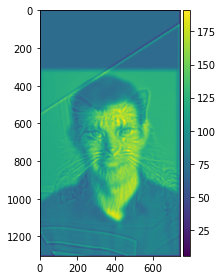

Lossy conversion from float64 to uint8. Range [-67.47533702757075, 120.87443137891361]. Convert image to uint8 prior to saving to suppress this warning.


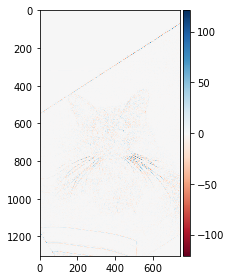

Lossy conversion from float64 to uint8. Range [-15.140255775763706, 35.89420636147787]. Convert image to uint8 prior to saving to suppress this warning.


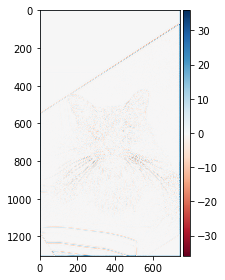

Lossy conversion from float64 to uint8. Range [-8.434422071148518, 22.549841919832332]. Convert image to uint8 prior to saving to suppress this warning.


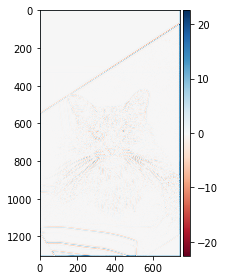

Lossy conversion from float64 to uint8. Range [-6.025999411835301, 16.912312840295343]. Convert image to uint8 prior to saving to suppress this warning.


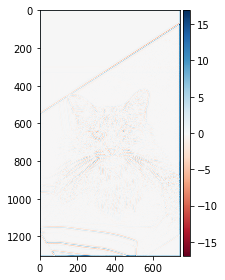

Lossy conversion from float64 to uint8. Range [-4.64148801314068, 13.124445621329315]. Convert image to uint8 prior to saving to suppress this warning.


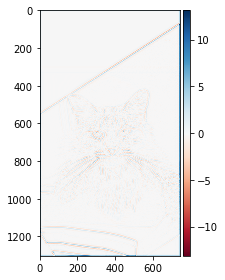

Lossy conversion from float64 to uint8. Range [-3.695546171868493, 10.472175318197472]. Convert image to uint8 prior to saving to suppress this warning.


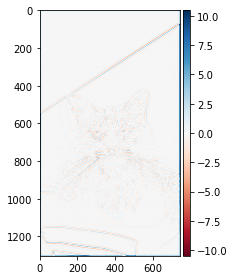

Lossy conversion from float64 to uint8. Range [-3.0372701347025313, 8.669117816431424]. Convert image to uint8 prior to saving to suppress this warning.


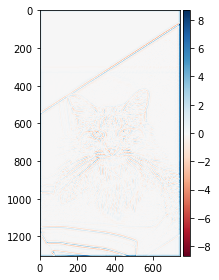

In [31]:
#show the hybrid procedure
right= sk.io.imread(fname="out/hybrid.jpg", as_gray=True)
num=7
G,L=parmid_mono(num,right)

for idex,i in enumerate(G):
    fname = "out/hybrid_G"+str(idex+1)+".jpg"
    skio.imsave(fname, G[idex])
    skio.imshow(G[idex])
    skio.show()
for idex,i in enumerate(L):
    fname = "out/hybrid_L"+str(idex+1)+".jpg"
    skio.imsave(fname, L[idex])
    skio.imshow(L[idex])
    skio.show()

Part 2.4: Multiresolution Blending <br>
The goal of this part of the assignment is to blend two images seamlessly using a multi resolution blending as described in the 1983 paper by Burt and Adelson. An image spline is a smooth seam joining two image together by gently distorting them. Multiresolution blending computes a gentle seam between the two images seperately at each band of image frequencies, resulting in a much smoother seam.<br>
-First, you'll need to get a few pairs of images that you want blend together with a vertical or horizontal seam. You can use the sample images for debugging, but you should use your own images in your results. Then you will need to write some code in order to use your Gaussian and Laplacian stacks from part 2 in order to blend the images together. Since we are using stacks instead of pyramids like in the paper, the algorithm described on page 226 will not work as-is. If you try it out, you will find that you end up with a very clear seam between the apple and the orange since in the pyramid case the downsampling/blurring/upsampling hoopla ends up blurring the abrupt seam proposed in this algorithm. Instead, you should always use a mask as is proposed in the algorithm on page 230, and remember to create a Gaussian stack for your mask image as well as for the two input images. The Gaussian blurring of the mask in the pyramid will smooth out the transition between the two images. For the vertical or horizontal seam, your mask will simply be a step function of the same size as the original images.<br>
-Now that you've made yourself an oraple (a.k.a your vertical or horizontal seam is nicely working), pick two pairs of images to blend together with an irregular mask, as is demonstrated in figure 8 in the paper.<br>
-Blend together some crazy ideas of your own!<br>
-Illustrate the process by applying your Laplacian stack and displaying it for your favorite result and the masked input images that created it. This should look similar to Figure 10 in the paper.<br>

In [293]:
G_1D=cv2.getGaussianKernel(30,20)
#2D Gaussian convolution
G_2D=np.outer(G_1D,G_1D.T)

def blur_color(image):
    shape=image.shape
    image_new=np.zeros([shape[0],shape[1],shape[2]])
    for i in range(3):
        image_G = signal.convolve2d(image[:,:,i], G_2D,  mode='same')
        image_new[:,:,i]=image_G     
    return image_new

def parmid(num,image):
    G_image=[]
    L_image=[]
    for i in range(num):
        if i==0:
            image1=blur_color(image)
            G_image.append(image1)
            
            image_delta=image-image1
            L_image.append(image_delta)
        else:
            image1=blur_color(G_image[i-1])
            G_image.append(image1)
            
            image_delta=G_image[i-1]-image1
            L_image.append(image_delta)
    return G_image,L_image

def Laplacian (image,image1):
    image2=image-image1
    return image2

def image_blending(num,mask,left,right):
    shape=left.shape
    I=np.ones([shape[0],shape[1],shape[2]])
    G_l,L_l=parmid(num,left)
    G_r,L_r=parmid(num,right)
    G_m,L_m=parmid(num,mask)
    LS=[]
    final_image=np.zeros([shape[0],shape[1],shape[2]])
    for i in range(num):
        LS.append(G_m[i]*L_l[i] + (I-G_m[i])*L_r[i])
        final_image=final_image+LS[i]
        
        if i==num-1:
            LS.append(G_m[i]*G_l[i] + (1-G_m[i])*G_r[i])
            final_image=final_image+LS[i+1]
            
    return final_image

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.009389594880877372, 1.014581631716044]. Convert image to uint8 prior to saving to suppress this warning.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


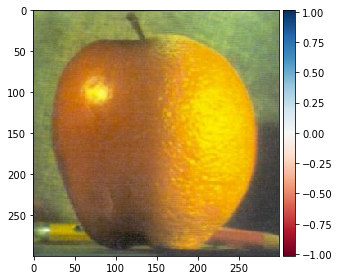

In [294]:
#orange+apple
right= sk.io.imread(fname="orange.jpeg")/255
left= sk.io.imread(fname="apple.jpeg")/255
shape=left.shape
mask=np.concatenate((np.ones([shape[0],int(shape[1]/2),shape[2]]),np.zeros([shape[0],int(shape[1]/2),shape[2]])),axis=1) 
fname = "mask.jpg"
skio.imsave(fname, mask)

final_image=image_blending(5,mask,left,right)


fname = "out/apple_orange.jpg"
skio.imsave(fname, final_image)
skio.imshow(final_image)
skio.show()



Lossy conversion from float64 to uint8. Range [-0.017098935364254164, 1.0765440191875237]. Convert image to uint8 prior to saving to suppress this warning.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


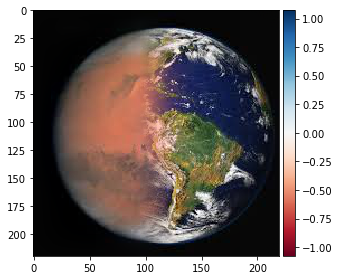

In [129]:
#earth+mars
right= sk.io.imread(fname="earth.jpeg")/255
right=right[:-1,:-9,:]
left= sk.io.imread(fname="mars.jpeg")/255
left=left[:-5,:-5,:]
shape=left.shape
mask=np.concatenate((np.ones([shape[0],int(shape[1]/2),shape[2]]),np.zeros([shape[0],int(shape[1]/2),shape[2]])),axis=1) 

final_image=image_blending(5,mask,left,right)

fname = "out/mars_earth.jpg"
skio.imsave(fname, final_image)
skio.imshow(final_image)
skio.show()


Lossy conversion from float64 to uint8. Range [0.0, 1.151390487775998]. Convert image to uint8 prior to saving to suppress this warning.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


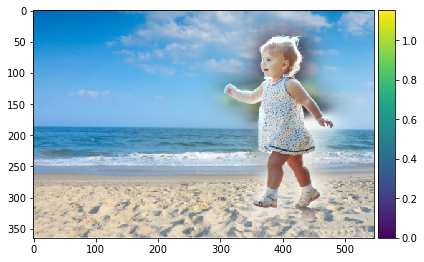

In [131]:
right= sk.io.imread(fname="beach.jpg")/255
right=resize(right, (right.shape[0]//5, right.shape[1]//5),right.shape[2])
left= sk.io.imread(fname="girl.jpg")/255
left=resize(left, (left.shape[0]//5, left.shape[1]//5),left.shape[2])
mask=sk.io.imread(fname="mask_girl.jpg")/255
mask=resize(mask, (mask.shape[0]//5, mask.shape[1]//5),mask.shape[2])

final_image=image_blending(5,mask,left,right)

fname = "out/girl_beach.jpg"
skio.imsave(fname, final_image)
skio.imshow(final_image)
skio.show()


Lossy conversion from float64 to uint8. Range [-0.07105687864237153, 0.9999747301642508]. Convert image to uint8 prior to saving to suppress this warning.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


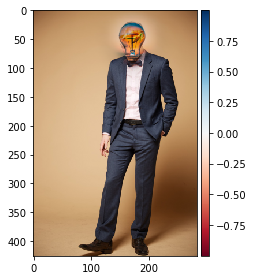

In [134]:
right= sk.io.imread(fname="man.jpg")/255
right=resize(right, (right.shape[0]//3, right.shape[1]//3),right.shape[2])
left= sk.io.imread(fname="bulb.jpg")/255
left=resize(left, (left.shape[0]//3, left.shape[1]//3),left.shape[2])
mask=sk.io.imread(fname="mask_bulb.jpg")/255
mask=resize(mask, (mask.shape[0]//3, mask.shape[1]//3),mask.shape[2])

final_image=image_blending(5,mask,left,right)

fname = "out/man_bulb.jpg"
skio.imsave(fname, final_image)
skio.imshow(final_image)
skio.show()

In [34]:
#show the blending procedure

def image_blending_mono(num,mask,left,right):
    shape=left.shape
    I=np.ones([shape[0],shape[1]])
    G_l,L_l=parmid_mono(num,left)
    G_r,L_r=parmid_mono(num,right)
    G_m,L_m=parmid_mono(num,mask)
    LS=[]
    final_image=np.zeros([shape[0],shape[1]])
    R=np.zeros([shape[0],shape[1]])
    L=np.zeros([shape[0],shape[1]])
    for i in range(num):
        LS.append(G_m[i]*L_l[i] + (I-G_m[i])*L_r[i])
        final_image=final_image+LS[i]
        L=L+G_m[i]*L_l[i]
        R=R+(I-G_m[i])*L_r[i]
        fname = "out/girl_beach_L"+str(i)+".jpg"
        skio.imsave(fname, L_l[i])
        
        fname = "out/girl_beach_R"+str(i)+".jpg"
        skio.imsave(fname, R)
        
        fname = "out/girl_beach_F"+str(i)+".jpg"
        skio.imsave(fname, final_image)
        
        if i==num-1:
            LS.append(G_m[i]*G_l[i] + (1-G_m[i])*G_r[i])
            final_image=final_image+LS[i+1]
            
    return final_image

Lossy conversion from float64 to uint8. Range [-0.45471306763764474, 0.4953897637762734]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.23002477170857427, 0.48595347139362977]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.34464252909794535, 0.48595347139362977]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.11584543893107196, 0.14169583680288622]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.2680591824913011, 0.6122197545774142]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.36709084641990863, 0.6122197545774142]. Convert image to uint8 prior to saving to suppress this warning.
<ipython-input-34-d03b044ea381>:19: UserWarning: out/girl_beach_L2.j

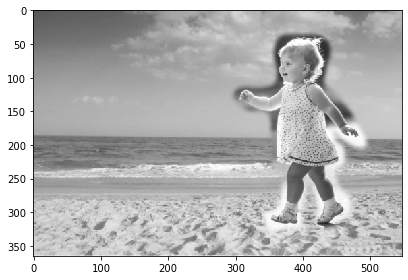

In [35]:
#show the blending procedure
right= sk.io.imread(fname="beach.jpg", as_gray=True)
right=resize(right, (right.shape[0]//5, right.shape[1]//5))
left= sk.io.imread(fname="girl.jpg", as_gray=True)
left=resize(left, (left.shape[0]//5, left.shape[1]//5))
mask=sk.io.imread(fname="mask_girl.jpg", as_gray=True)
mask=resize(mask, (mask.shape[0]//5, mask.shape[1]//5))

final_image=image_blending_mono(5,mask,left,right)

fname = "out/girl_beach_mono.jpg"
skio.imsave(fname, final_image)
skio.imshow(final_image)
skio.show()


In [10]:
right= sk.io.imread(fname="orange.jpeg")
right=resize(right, (right.shape[0], right.shape[1],right.shape[2]))
fname = "orange_1.jpg"
skio.imsave(fname, right)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
